In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import mibian as mb

In [3]:
data = yf.download("EBAY", start="2020-03-01", end="2021-03-02")

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,34.619999,35.970001,34.279999,35.959999,35.500446,13131000
2020-03-03,35.730000,37.419998,35.660000,36.720001,36.250732,18838700
2020-03-04,37.320000,38.540001,37.139999,38.490002,37.998116,13445400
2020-03-05,37.480000,38.220001,37.070000,37.220001,36.744343,11816600
2020-03-06,35.709999,36.790001,35.590000,36.389999,35.924953,12849800


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-23,60.680000,61.730000,59.820000,61.369999,61.176132,5826500
2021-02-24,60.990002,61.049999,58.830002,59.380001,59.192421,8050000
2021-02-25,59.400002,59.970001,56.849998,56.980000,56.799999,7868300
2021-02-26,57.340000,57.660000,56.250000,56.419998,56.419998,9013500
2021-03-01,57.099998,58.700001,56.529999,58.480000,58.480000,6153700


In [6]:
ADJ =  data['Adj Close']

In [7]:
ADJ

Date
2020-03-02    35.500446
2020-03-03    36.250732
2020-03-04    37.998116
2020-03-05    36.744343
2020-03-06    35.924953
                ...    
2021-02-23    61.176132
2021-02-24    59.192421
2021-02-25    56.799999
2021-02-26    56.419998
2021-03-01    58.480000
Name: Adj Close, Length: 252, dtype: float64

Text(0, 0.5, 'Adj Close')

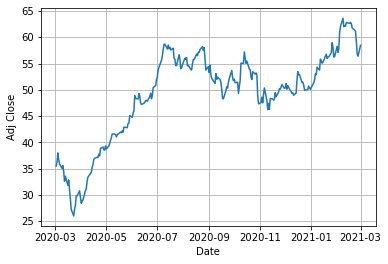

In [8]:
fig = plt.figure()
plt.plot( ADJ, '-')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Adj Close')

array([<AxesSubplot:xlabel='Date'>], dtype=object)

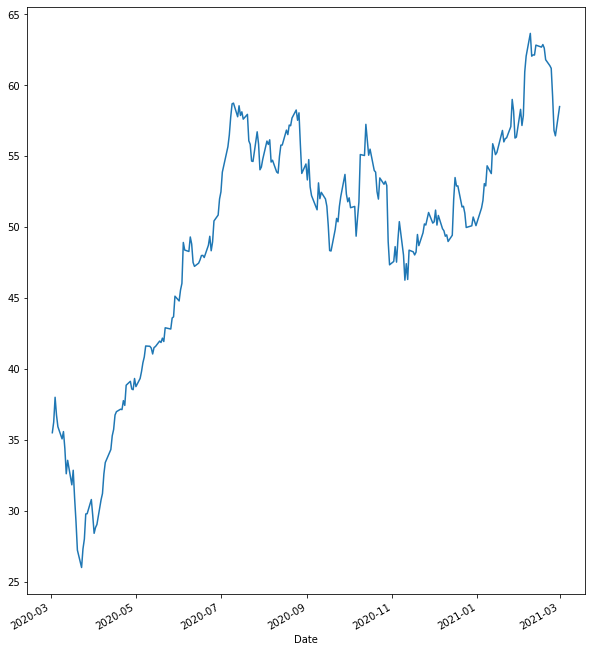

In [19]:
ADJ.plot(figsize=(10, 12), subplots=True)

In [9]:
ADJ.describe().round(2)

count    252.00
mean      49.01
std        8.63
min       26.00
25%       45.04
50%       50.82
75%       55.30
max       63.64
Name: Adj Close, dtype: float64

### Annualised volatility

In [29]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [30]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 37.59 %


In [92]:
Sixlr = log_return[126:-1]

In [95]:
Sixlr

Date
2020-05-12   -0.003090
2020-05-13   -0.010050
2020-05-14    0.011002
2020-05-15    0.001664
2020-05-18    0.009219
                ...   
2021-02-22   -0.006799
2021-02-23   -0.003091
2021-02-24   -0.032964
2021-02-25   -0.041257
2021-02-26   -0.006713
Name: Adj Close, Length: 201, dtype: float64

In [96]:
Vol = np.sqrt(252) * Sixlr.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 37.59 %


### European Options
Non-Dividend Paying Options

In [81]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
#S: spot price
#K: strike price
#T: time to maturity
#r: interest rate
#vol: volatility of underlying asset
#payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [82]:
S = data['Adj Close'][-1]
K = 3000
T = 3/12
r = 0.0167
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
vol = np.sqrt(252) * log_return.std() 
vol

0.3759084055418103

In [83]:
euro_option_bs(S, K, T, r, vol, 'call')

5.537211476326554e-97

In [84]:
euro_option_bs(S, K, T, r, vol, 'put')

2929.021110046781

Dividend Paying Options

In [85]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [86]:
euro_option_bsm(S, 3000, 3/12, 0.0167, 0.0121, vol, 'put')
print('The BS put price is', round(put,2))

The BS put price is 2929.02


### Mibian - Options Price Library

In [25]:
option_100 = mb.BS([S, K, r*100, vol], volatility = vol*100)

In [27]:
option_100.putPrice

2941.4684036107415